# Momentum on MOEX exchange stocks

1. Выгружаем данные в SQLite базу
  - отбираем с капитализацией более 100 млрд. руб
2. Строим график для примера
3. Делаем расчеты
4. Проходим по параметрам типа GridSearch
  - переменные начала и окончание бэктеста
  - временной горизонт определения winners и losers    

In [2]:
# Data
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:.4f}'.format
import pandas_datareader.data as reader
from dateutil.relativedelta import relativedelta
import numpy as np
import datetime as dt

# Vizualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other
import sqlalchemy
import yfinance as yf
import mplfinance as mpf
import warnings
warnings.filterwarnings("ignore")

In [3]:
CAPI_THRESHOLD = 10E+10
START = dt.datetime(2016, 6, 30)
END = dt.datetime(2021, 8, 20)

## 1. Creating a SQL database

### 1.1 Reading data

In [4]:
stocks = pd.read_html("https://www.moex.com/a7714", flavor='html5lib')[0]
print(f'Итого тикеров в таблице: {stocks.shape[0]}')
stocks.head()

Итого тикеров в таблице: 261


,Торговый код ценной бумаги,Краткое наименование эмитента ценной бумаги,"Категория ценной бумаги (ао - акция обыкновенная, ап - акция привилегированная)",Государственный регистрационный номер выпуска (дополнительного выпуска)*,"Объем выпуска, штук","Рыночная цена (3) на 31.03.2021, руб.","Капитализация, руб."
0,ABRD,"ПАО ""Абрау – Дюрсо""",aо,1-02-12500-A,98 000 184,2125.0000,"20 825 039 100,00"
1,ACKO,"ПАО ""АСКО-СТРАХОВАНИЕ""",aо,1-01-52065-Z,536 000 000,638.0000,"3 419 680 000,00"
2,AFKS,"ПАО АФК ""Система""",aо,1-05-01669-A,9 650 000 000,34178.0000,"329 817 700 000,00"
3,AFLT,"ПАО ""Аэрофлот-российские авиалинии""",aо,1-01-00010-A,2 444 535 448,6724.0000,"164 370 563 523,52"
4,AKRN,"ПАО ""Акрон""",aо,1-03-00207-A,40 534 000,6204.0000,"251 472 936 000,00"


In [5]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Торговый код ценной бумаги                                                       261 non-null    object 
 1   Краткое наименование эмитента ценной бумаги                                      261 non-null    object 
 2   Категория ценной бумаги (ао - акция обыкновенная, ап - акция привилегированная)  261 non-null    object 
 3   Государственный  регистрационный  номер выпуска  (дополнительного  выпуска)*     261 non-null    object 
 4   Объем выпуска, штук                                                              261 non-null    object 
 5   Рыночная цена (3) на 31.03.2021, руб.                                            246 non-null    float64
 6   Капитализац

Капитализацию переведем в тип данных float:

In [6]:
stocks['Капитализация, руб.'] = stocks['Капитализация, руб.'].str.replace(' ', '')
stocks['Капитализация, руб.'] = stocks['Капитализация, руб.'].str.replace(',', '.')
stocks['Капитализация, руб.'] = stocks['Капитализация, руб.'].astype('float')

Добавим .ME к названию тикера, чтобы Yahoo корректно отвечал:

In [7]:
stocks['Торговый код ценной бумаги Yahoo'] = stocks['Торговый код ценной бумаги'] + '.ME'
stocks.sample(5)

,Торговый код ценной бумаги,Краткое наименование эмитента ценной бумаги,"Категория ценной бумаги (ао - акция обыкновенная, ап - акция привилегированная)",Государственный регистрационный номер выпуска (дополнительного выпуска)*,"Объем выпуска, штук","Рыночная цена (3) на 31.03.2021, руб.","Капитализация, руб.",Торговый код ценной бумаги Yahoo
175,RLMNP,"ПАО ""ГК ""Роллман""",ап,2-01-05257-D,1 560 000,1352.0000,21091200.0000,RLMNP.ME
70,JNOS,"ПАО ""Славнефть-ЯНОС""",aо,1-01-00199-A,932 654 723,189.0000,17627174264.7000,JNOS.ME
106,LSNG,"ПАО ""Россети Ленэнерго""",aо,1-01-00073-A,8 523 785 320,601.0000,51227949773.2000,LSNG.ME
170,RBCM,"ПАО ""РБК""",aо,1-02-56413-H,365 631 010,356.0000,1301646395.6000,RBCM.ME
197,SBERP,ПАО Сбербанк,ап,20301481B,1 000 000 000,27142.0000,271420000000.0000,SBERP.ME


### 1.2 Slicing tickers by capitalization

In [8]:
tickers = stocks[stocks['Капитализация, руб.'] > CAPI_THRESHOLD]['Торговый код ценной бумаги Yahoo']
tickers.sample(5)

# удаляем из Series Петропавловск PLC ('POGR.ME'), т.к. по нему данные очень короткие
tickers = tickers[tickers != 'POGR.ME']

### 1.3 SQL engine

In [9]:
def getdata(tickers):
    """get yahoo finance data for selected tickers"""
    try:
        data = []
        for ticker in tickers:
            print(f'Downloading {ticker}')
            data.append(yf.download(ticker).reset_index())
        return data
    except:
        print('Check tickers list')

In [10]:
MOEX = getdata(tickers=tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [11]:
def createengine(name):
    engine = sqlalchemy.create_engine('sqlite:///' + name)
    return engine

def transfer_SQL(frames, symbols, engine):
    """created each ticker to separate table into the database"""
    for frame, symbol in zip(frames, symbols):
        print(frame, symbol)
        frame.to_sql(symbol, engine, index=False)
    print('Succesfully imported data')

In [12]:
MOEX_engine = createengine('MOEX')

# с каждым набором данных используем его тикер
transfer_SQL(MOEX, tickers, MOEX_engine)

           Date    Open    High     Low   Close  Adj Close    Volume
0    2011-11-21 22.3100 22.3100 21.7000 21.8940    15.6635   1273900
1    2011-11-22 22.0000 22.5400 21.8910 22.5400    16.1256   2180400
2    2011-11-23 22.0000 23.7500 21.9500 23.2000    16.5978      6156
3    2011-11-24 23.6700 24.2240 23.4000 23.8710    17.0779   2361600
4    2011-11-25 23.8600 24.0000 23.5910 24.0000    17.1702   2113500
...         ...     ...     ...     ...     ...        ...       ...
2432 2021-08-17 29.3000 29.4710 29.1850 29.3200    29.3200  19382601
2433 2021-08-18 29.2990 29.4830 29.2020 29.3740    29.3740  13712207
2434 2021-08-19 29.2610 29.3090 28.6620 28.8120    28.8120  22985977
2435 2021-08-20 28.7000 28.7930 28.4250 28.5110    28.5110  21904401
2436 2021-08-23 28.6000 29.2990 28.5010 29.1350    29.1350  23097300

[2437 rows x 7 columns] AFKS.ME
           Date    Open    High     Low   Close  Adj Close    Volume
0    2010-03-03 55.5800 55.5800 54.3000 55.1000    39.5641    547540
1

           Date      Open      High       Low     Close  Adj Close  Volume
0    2010-03-03  732.9900  732.9900  712.5400  725.0000   439.1998    7479
1    2010-03-04  724.9700  729.7000  718.0000  720.0000   436.1708    1193
2    2010-03-05  723.9800  725.0000  705.1000  717.2800   434.5231    6032
3    2010-03-09  690.0000  717.2900  681.0000  712.0000   431.3245    3167
4    2010-03-10  712.4800  714.9800  685.0000  701.2700   424.8244    1231
...         ...       ...       ...       ...       ...        ...     ...
2860 2021-08-17 2461.5000 2494.5000 2420.0000 2474.0000  2474.0000   10542
2861 2021-08-18 2411.0000 2474.5000 2400.0000 2432.0000  2432.0000   14352
2862 2021-08-19 2429.5000 2429.5000 2370.0000 2375.5000  2375.5000    7266
2863 2021-08-20 2412.0000 2412.0000 2341.5000 2380.5000  2380.5000    6682
2864 2021-08-23 2370.5000 2480.0000 2370.5000 2479.5000  2479.5000   15914

[2865 rows x 7 columns] GCHE.ME
           Date       Open       High        Low      Close  Adj Cl

           Date     Open     High      Low    Close  Adj Close  Volume
0    2010-03-03 156.8900 156.8900 153.2000 154.0300    69.5559    7630
1    2010-03-04 153.6800 155.9600 141.2000 151.4900    68.4089   34908
2    2010-03-05 152.4200 152.9500 151.3900 152.5000    68.8650   17550
3    2010-03-09 151.9000 153.0000 151.0000 151.5100    68.4179    9166
4    2010-03-10 151.3000 153.9900 149.9700 150.9900    68.1831   12250
...         ...      ...      ...      ...      ...        ...     ...
2860 2021-08-17 640.6000 644.2000 638.0000 640.5000   640.5000  151354
2861 2021-08-18 652.8000 659.8000 647.5000 652.0000   652.0000  456328
2862 2021-08-19 646.5000 649.1000 630.0000 645.3000   645.3000  302404
2863 2021-08-20 642.9000 645.2000 635.4000 645.3000   645.3000  169340
2864 2021-08-23 640.0000 644.7000 636.2000 638.9000   638.9000  156284

[2865 rows x 7 columns] MVID.ME
           Date     Open     High      Low    Close  Adj Close   Volume
0    2010-03-03  16.3550  17.3000  16.0000 

           Date     Open     High      Low    Close  Adj Close    Volume
0    2010-03-03 237.0000 238.9000 234.2400 238.3500   157.2968   5183045
1    2010-03-04 236.8000 239.9900 235.2500 238.5000   157.3958   5847338
2    2010-03-05 239.8000 243.7700 237.8500 243.4400   160.6559   5401716
3    2010-03-09 243.0000 243.4400 236.7100 239.7800   158.2405   5812857
4    2010-03-10 239.0100 242.0500 236.3400 237.5000   156.7359   5514502
...         ...      ...      ...      ...      ...        ...       ...
2860 2021-08-17 562.9500 563.0000 552.9000 555.7000   555.7000   8953003
2861 2021-08-18 557.8000 559.9000 554.1000 555.6000   555.6000   7919571
2862 2021-08-19 544.0000 547.7500 531.4500 534.6000   534.6000  10787540
2863 2021-08-20 537.5000 538.2500 530.1000 533.5000   533.5000   3106435
2864 2021-08-23 538.0000 545.4500 536.1000 544.7500   544.7500   3074360

[2865 rows x 7 columns] ROSN.ME
           Date   Open   High    Low  Close  Adj Close     Volume
0    2010-03-03 4.1020 4.

[2865 rows x 7 columns] TRNFP.ME
           Date   Open   High    Low  Close  Adj Close    Volume
0    2013-09-17 0.1220 0.1300 0.1185 0.1220     0.1203     22950
1    2013-09-18 0.1212 0.1240 0.1212 0.1212     0.1194     24700
2    2013-09-19 0.1220 0.1419 0.1213 0.1220     0.1203     19430
3    2013-09-20 0.1223 0.1248 0.1223 0.1223     0.1206       650
4    2013-09-23 0.1224 0.1310 0.1222 0.1224     0.1207      6750
...         ...    ...    ...    ...    ...        ...       ...
1983 2021-08-17 0.6900 0.6900 0.6400 0.6560     0.6560  15088091
1984 2021-08-18 0.6570 0.6970 0.6470 0.6560     0.6560   9939000
1985 2021-08-19 0.6665 0.6675 0.6425 0.6710     0.6710   3662000
1986 2021-08-20 0.6550 0.6700 0.6430 0.6550     0.6550   1140006
1987 2021-08-23 0.6640 0.6795 0.6520 0.6665     0.6665   2156000

[1988 rows x 7 columns] UNAC.ME
           Date   Open   High    Low  Close  Adj Close    Volume
0    2011-11-21 2.3260 2.3270 2.2500 2.2500     0.8843   7203000
1    2011-11-22 2.2850 2

Напишем тестовый запрос:

In [13]:
query = '''PRAGMA table_info("GAZP.ME");
        '''

pd.read_sql(query, MOEX_engine)

,cid,name,type,notnull,dflt_value,pk
0,0,Date,DATETIME,0,None,0
1,1,Open,FLOAT,0,None,0
2,2,High,FLOAT,0,None,0
3,3,Low,FLOAT,0,None,0
4,4,Close,FLOAT,0,None,0
5,5,Adj Close,FLOAT,0,None,0
6,6,Volume,BIGINT,0,None,0


## 2. Graphics view

Забираем данные для исследуемого тикера из базы:

In [14]:
query = '''SELECT *
           FROM "GAZP.ME";
        '''

GAZP = pd.read_sql(query, MOEX_engine)

GAZP.index = pd.DatetimeIndex(GAZP['Date'])
GAZP.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2021-08-17,2021-08-17 00:00:00.000000,295.0000,299.5000,294.7100,298.2200,298.2200,39767160
2021-08-18,2021-08-18 00:00:00.000000,299.0000,299.9500,296.5000,298.3500,298.3500,31731140
2021-08-19,2021-08-19 00:00:00.000000,293.4600,293.5600,289.6800,292.8500,292.8500,51828350
2021-08-20,2021-08-20 00:00:00.000000,293.8000,294.9000,289.5000,292.7900,292.7900,36598680
2021-08-23,2021-08-23 00:00:00.000000,294.7000,297.8900,294.1000,297.1200,297.1200,34833830


In [15]:
mpf.available_styles()

['binance',
 'blueskies',
 'brasil',
 'charles',
 'checkers',
 'classic',
 'default',
 'ibd',
 'kenan',
 'mike',
 'nightclouds',
 'sas',
 'starsandstripes',
 'yahoo']

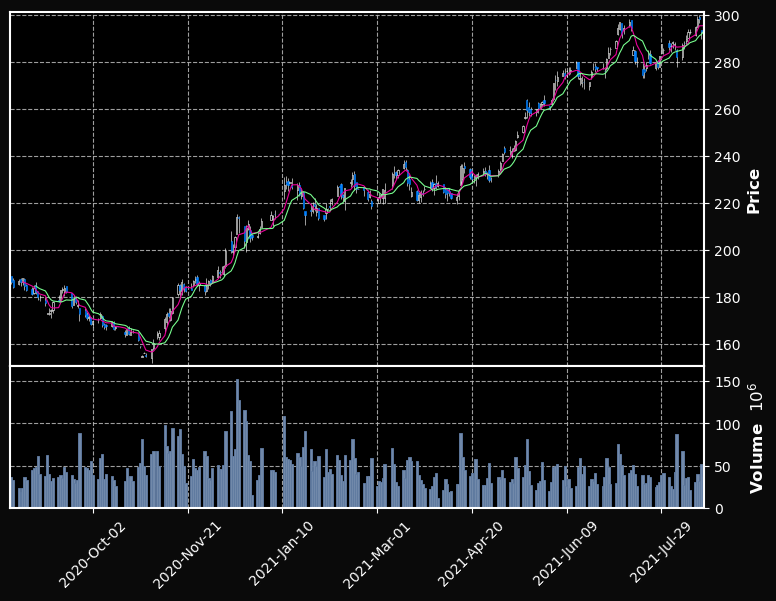

In [16]:
# mav - moving average
mpf.plot(GAZP.loc['2020-08-20':'2021-08-20',:], type='candle', volume=True, mav=(5, 10), 
         tight_layout=True, style='mike', show_nontrading=True)

Далее ищем пересечение скользящих средних (выше-ниже).

## 3. Build strategy

### 3.1 Momentum to ticker
Выбираем инструмент:

In [99]:
ticker = GAZP.loc['2019-08-20':'2021-08-20',:].copy()

ticker.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2019-08-20,2019-08-20 00:00:00.000000,226.5800,232.3200,226.1500,231.5400,204.2695,34636220
2019-08-21,2019-08-21 00:00:00.000000,231.8000,232.3200,230.5000,231.2200,203.9872,20502100
2019-08-22,2019-08-22 00:00:00.000000,230.9000,233.9800,230.2100,232.0600,204.7282,26486570


Определяем дневную доходность как: 
$$return = \frac{price_{today}}{price_{yesterday}} - 1$$

In [100]:
ticker['day_return_simple'] = (ticker.Close / ticker.Close.shift(1)) - 1
ticker.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,day_return_simple
Date,,,,,,,,
2019-08-20,2019-08-20 00:00:00.000000,226.5800,232.3200,226.1500,231.5400,204.2695,34636220,nan
2019-08-21,2019-08-21 00:00:00.000000,231.8000,232.3200,230.5000,231.2200,203.9872,20502100,-0.0014
2019-08-22,2019-08-22 00:00:00.000000,230.9000,233.9800,230.2100,232.0600,204.7282,26486570,0.0036


Или используя pct_change():

In [101]:
ticker['day_return'] = ticker.Close.pct_change()
ticker.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,day_return_simple,day_return
Date,,,,,,,,,
2019-08-20,2019-08-20 00:00:00.000000,226.5800,232.3200,226.1500,231.5400,204.2695,34636220,nan,nan
2019-08-21,2019-08-21 00:00:00.000000,231.8000,232.3200,230.5000,231.2200,203.9872,20502100,-0.0014,-0.0014
2019-08-22,2019-08-22 00:00:00.000000,230.9000,233.9800,230.2100,232.0600,204.7282,26486570,0.0036,0.0036


In [102]:
ticker.drop('day_return_simple', axis=1, inplace=True)

Используем Log returns, чтобы проще посчитать кумулятивную доходность как сумму междневных, а затем экспонируем:

In [103]:
ticker['log_return'] = np.log(ticker['day_return'] + 1) # +1 чтобы не было ошибки нуля
ticker.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day_return,log_return
Date,,,,,,,,,
2019-08-20,2019-08-20 00:00:00.000000,226.5800,232.3200,226.1500,231.5400,204.2695,34636220,nan,nan
2019-08-21,2019-08-21 00:00:00.000000,231.8000,232.3200,230.5000,231.2200,203.9872,20502100,-0.0014,-0.0014
2019-08-22,2019-08-22 00:00:00.000000,230.9000,233.9800,230.2100,232.0600,204.7282,26486570,0.0036,0.0036
2019-08-23,2019-08-23 00:00:00.000000,232.7000,233.0400,228.9300,229.3500,202.3374,29021720,-0.0117,-0.0117
2019-08-26,2019-08-26 00:00:00.000000,228.8800,230.6000,228.0500,228.9000,201.9404,11237140,-0.0020,-0.0020


Детальный расчет: 

In [104]:
# от первого дня к последнему доходность:
last_day_number = ticker.shape[0] - 1

interval_return = ((ticker.Close / ticker.Close.shift(last_day_number)) - 1).tail(1)
print('Доходность за заданный период: {:.2%}'.format(float(interval_return.values)))

Доходность за заданный период: 26.45%


Используя логарифм:

In [105]:
interval_return = np.exp(ticker.log_return.sum()) - 1
print('Доходность за заданный период: {:.2%}'.format(float(interval_return)))

Доходность за заданный период: 26.45%


**Выше baseline по стратегии "buy & hold".**  


Теперь рассчитаем доходность используя скользящие.

In [106]:
def strategy(df, sma1, sma2):
    df['market_return'] = np.log(df.Close.pct_change() + 1)
    df['SMA1'] = df.Close.rolling(sma1).mean()
    df['SMA2'] = df.Close.rolling(sma2).mean()
    df = df.dropna()
    df['position'] = np.where(df.SMA1 > df.SMA2, 1, 0)
    df['strat_return'] = df.position.shift(1) * df.market_return
    df = df.dropna()
    return df

def performance(df):
    return np.exp(df[['market_return', 'strat_return']].sum())

Пример разметки встаем в позицию или нет:

In [107]:
performance(strategy(ticker, sma1=20, sma2=50))

market_return   1.1980
strat_return    1.3818
dtype: float64

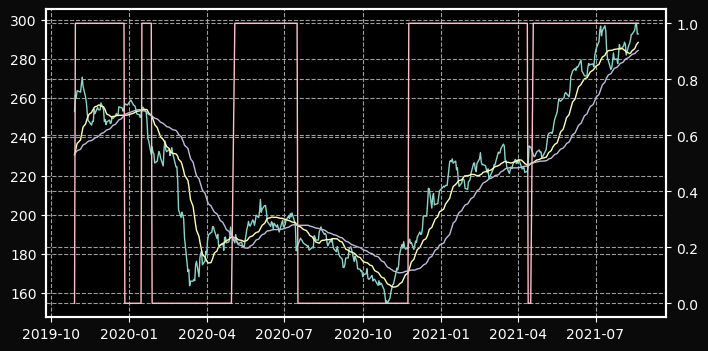

In [108]:
stratdf = strategy(ticker, 20, 50)

fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()
ax.plot(stratdf[['Close', 'SMA1', 'SMA2']])
ax2.plot(stratdf['position'], color='pink')
plt.show()

### 3.2 Simle SMA's GridSearch

In [109]:
# simple grid search
list_SMA1 = range(5, 100, 5)
list_SMA2 = range(105, 201, 5)

In [110]:
def Tester(data, list_SMA1, list_SMA2):
    profits = []
    SMA1, SMA2 = [], []

    for i, e in zip(list_SMA1, list_SMA2):
        profit = performance(strategy(data, i, e))
        profits.append(profit)
        SMA1.append(i)
        SMA2.append(e)
    
    col = {'level_0':'SMA1', 
           'level_1':'SMA2'}
    frame = pd.DataFrame(profits, [SMA1, SMA2]).reset_index().rename(columns=col)
    
    frame['diff'] = frame['strat_return'] - frame['market_return']
    frame['diff_%'] = (frame['strat_return'] - frame['market_return']) * 100
    return frame.sort_values('diff', ascending=False)

In [111]:
test_result = Tester(ticker, list_SMA1, list_SMA2) 
test_result

,SMA1,SMA2,market_return,strat_return,diff,diff_%
2,15,115,1.2862,1.5772,0.2910,29.1013
4,25,125,1.2526,1.5378,0.2852,28.5185
3,20,120,1.3001,1.5515,0.2514,25.1401
5,30,130,1.3031,1.4682,0.1651,16.5066
1,10,110,1.2677,1.3896,0.1219,12.1904
0,5,105,1.1550,1.2604,0.1055,10.5450
6,35,135,1.4532,1.3715,-0.0817,-8.1686
18,95,195,1.4643,1.3410,-0.1233,-12.3273
14,75,175,1.5102,1.3638,-0.1465,-14.6459
17,90,190,1.5065,1.3485,-0.1581,-15.8054


Посмотрим на 3D распределение доходнисти в зависимости от SMA1 и SMA2:

In [112]:
fig = go.Figure(data=[go.Surface(
                        x = test_result['SMA1'],
                        y = test_result['SMA2'],
                        z = np.tile(test_result['diff_%'].values, 
                                    [test_result['diff_%'].values.shape[0], 1]),
                        colorscale=['red', 'green'])
                     ])
    
fig.update_layout(
            title = 'Разница в доходности между стратегией и рынком:',
            scene = dict(
                    xaxis_title = 'SMA1 (slow)',
                    yaxis_title = 'SMA2 (fast)',
                    zaxis_title = 'diff_%',
                    bgcolor = "whitesmoke"
                    #"xaxis": {"nticks": 10},
                    #"zaxis": {"nticks": 10},
                    #"camera_eye": {"x": 0, "y": -1, "z": 0.5},
                    #"aspectratio": {"x": 1, "y": 1, "z": 1}
                    ),
            width=800, 
            height=500
            )                 

fig.show()

# https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Surface.html
# https://github.com/plotly/plotly.js/issues/4807

### 3.3 Momentum to MOEX index

сводно по всем выбранным тикерам:

In [113]:
%%time
# период бэктеста определяем глобальными переменным в начале
df = reader.get_data_yahoo(tickers.to_list(), START, END)['Adj Close']
df.head()

Wall time: 1min 9s


Symbols,AFKS.ME,AFLT.ME,AKRN.ME,ALRS.ME,APTK.ME,BANE.ME,CBOM.ME,CHMF.ME,DSKY.ME,ENPG.ME,FEES.ME,FLOT.ME,GAZP.ME,GCHE.ME,GMKN.ME,HYDR.ME,IRAO.ME,KZOS.ME,LKOH.ME,MAGN.ME,MGNT.ME,MGTS.ME,MOEX.ME,MTSS.ME,MVID.ME,NKNC.ME,NLMK.ME,NMTP.ME,NVTK.ME,PHOR.ME,PIKK.ME,PLZL.ME,POLY.ME,RASP.ME,RGSS.ME,ROSB.ME,ROSN.ME,RSTI.ME,RTKM.ME,RUAL.ME,SBER.ME,SBERP.ME,SIBN.ME,SNGS.ME,SNGSP.ME,TATN.ME,TRNFP.ME,UNAC.ME,UPRO.ME,VSMO.ME,VTBR.ME,YAKG.ME,YNDX.ME
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-30,16.5054,72.5514,2404.3215,38.9958,9.8877,2085.0811,3.9061,360.8893,nan,nan,0.0942,nan,95.6966,653.0291,5316.0806,0.4407,2.0854,26.6797,1814.5774,15.2339,6472.8447,531.8523,80.1288,121.9390,258.4197,33.8756,45.0646,2.4064,574.9547,1905.3011,202.5516,3665.9412,880.2495,25.9532,0.3534,44.0000,270.1606,0.5343,60.6527,20.2052,80.1199,51.5401,117.8731,28.5708,20.4036,193.9728,123277.0000,0.5250,1.6032,7387.9346,0.0548,18.4758,1399.0000
2016-07-01,17.2318,72.9841,2359.6060,38.5512,9.8962,2064.0842,3.9208,375.3424,nan,nan,0.0952,nan,96.0670,650.7563,5288.6909,0.4512,2.0408,26.6084,1830.1273,15.3767,6536.7690,527.1270,80.0718,122.9424,256.3640,33.6843,45.4447,2.4662,571.9362,1894.9351,201.9844,3654.2312,884.7330,26.7822,0.3553,42.8000,272.1664,0.5305,60.1922,20.1353,80.6320,51.9982,119.2246,28.3600,20.5125,193.9728,123277.0000,0.5310,1.6361,7369.2480,0.0552,17.5283,1403.0000
2016-07-04,17.1834,72.2713,2383.6831,39.1140,9.9302,2070.8455,3.9306,367.2890,nan,nan,0.1013,nan,97.1303,648.4836,5515.9004,0.4464,2.0160,26.4657,1855.8177,15.5068,6568.3726,536.0525,80.3994,125.2890,256.7923,34.1308,45.6673,2.4252,569.5391,1878.3491,202.3895,3654.2312,916.1169,27.5291,0.3562,44.0000,271.1430,0.5324,60.4882,21.1740,81.0838,51.9581,118.4576,28.4332,20.7251,191.5152,122462.5391,0.5305,1.6386,7369.2480,0.0552,15.6333,1390.0000
2016-07-05,17.4416,73.3829,2376.8044,39.1702,9.9727,2072.6252,3.9012,371.4231,nan,nan,0.1005,nan,96.6844,653.0291,5483.5322,0.4448,2.1077,26.3944,1872.3820,15.0435,6428.3130,537.1025,78.8897,125.1294,254.1370,34.2584,44.5868,2.5161,562.9691,1830.6647,202.5516,3666.7217,909.1428,26.2265,0.3544,44.9000,269.6694,0.5650,60.4553,20.9643,79.4272,50.9674,119.7725,28.3084,21.0093,188.4139,120907.7188,0.5265,1.6323,7356.7886,0.0549,15.6333,1383.0000
2016-07-06,17.1309,73.3575,2373.3643,38.6694,10.0236,2026.7172,3.8865,376.3626,nan,nan,0.0989,nan,96.0259,651.5139,5460.4995,0.4425,2.0986,26.9651,1847.0289,15.7290,6291.8462,535.0024,79.0464,125.1560,251.3960,34.4498,45.6836,2.4633,561.1047,1782.9805,201.6603,3661.2561,945.5084,25.7072,0.3544,45.1000,262.3833,0.6135,60.5277,20.7645,77.9272,50.5436,118.5671,27.6545,21.1741,187.9166,120389.4297,0.5210,1.6650,7350.5581,0.0551,13.7384,1372.0000


In [114]:
def nan_check(data, columns):
    '''Создаёт тепловую карту пропусков для общей визуализации их количества,
    если признаков так много, что не помещаются на один рисунок, то следует 
    подавать на вход датафрейм по частям (столбцам)'''
    
    # зеленым цветом (#66ff00) - непропущенные, 
    # красным цветом (#d41243) - пропущенные данные 
    colors = ['#66ff00', '#d41243'] 
    fig, ax = plt.subplots(figsize=(12,4)) 
    sns.set_style('darkgrid')
    sns.heatmap(data[columns].isna(), cmap=sns.color_palette(colors), cbar=False, ax=ax)
    plt.yticks([])
    plt.title('Тепловая карта пропусков (пропуски красным цветом)', fontsize=14)
    plt.show()
    
    print('На наличие NaN значений в относительном выражении в %:\n',
          data.isna().mean().sort_values(ascending=False).head())

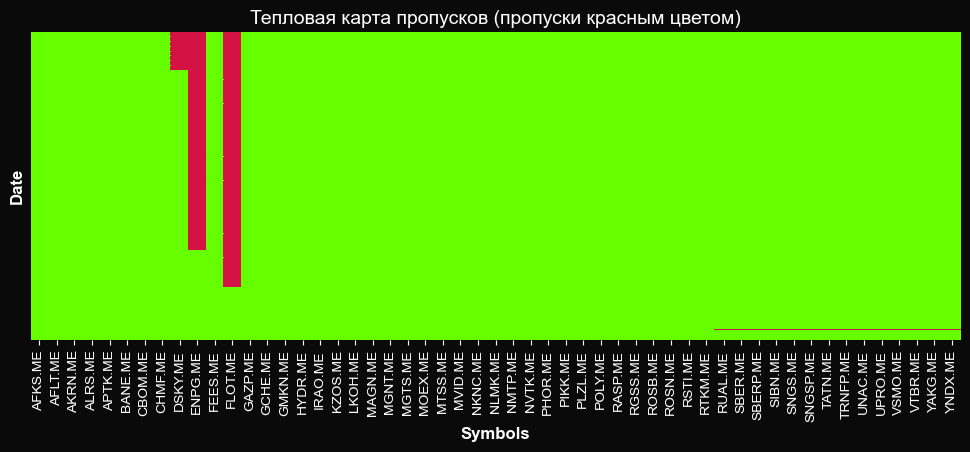

На наличие NaN значений в относительном выражении в %:
 Symbols
FLOT.ME   0.8302
ENPG.ME   0.7083
DSKY.ME   0.1227
SNGS.ME   0.0039
YAKG.ME   0.0039
dtype: float64


In [115]:
nan_check(df, columns=df.columns)

Удалим эмитентов с пропусками: (#TODО найти альтернативный источник)

In [116]:
df = df.drop(['DSKY.ME', 'ENPG.ME', 'FLOT.ME'], axis=1)

Рассчитаем изменение цены за каждый день и по ним кумулятивное изменение за месяц:

In [117]:
month_return = df.pct_change().resample('M').agg(lambda x:(x+1).prod() - 1)

В модели Фамы-Френча моментум определяется как 12 за вычетом 1, т.е. последний месяц не учитываем

In [118]:
past_11 = (month_return + 1).rolling(11).apply(np.prod) - 1

In [119]:
formation = dt.datetime(2021,1,31)

end_measurment = formation - relativedelta(months=1)
print(formation, end_measurment)

2021-01-31 00:00:00 2020-12-31 00:00:00


In [120]:
return_12 = past_11.loc[end_measurment]
return_12 = return_12.reset_index()
return_12.columns = ['ticker', 'returns']
return_12.sort_values(by='returns', ascending=False)

,ticker,returns
28,PLZL.ME,1.0013
49,YNDX.ME,0.7948
23,NLMK.ME,0.7441
7,CHMF.ME,0.6102
29,POLY.ME,0.6058
17,MGNT.ME,0.5842
0,AFKS.ME,0.5782
30,RASP.ME,0.5661
19,MOEX.ME,0.5447
31,RGSS.ME,0.5268


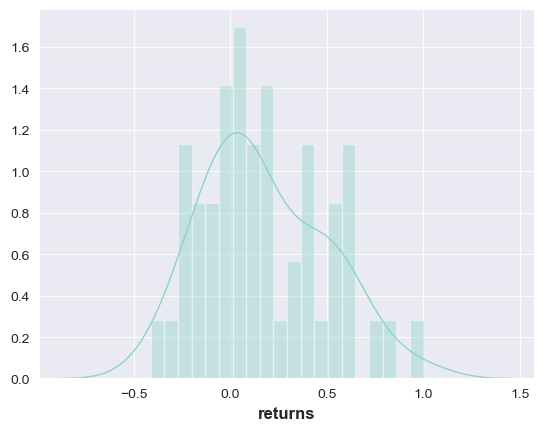

In [121]:
sns.distplot(return_12['returns'], bins=20, label='asdf')
plt.show()

Находим лучших и худших на данном периоде:

In [122]:
# find winners and losers
return_12['quintile'] = pd.qcut(return_12.iloc[:,1], 5, labels=False)
return_12

,ticker,returns,quintile
0,AFKS.ME,0.5782,4
1,AFLT.ME,-0.3358,0
2,AKRN.ME,0.3222,3
3,ALRS.ME,0.2794,3
4,APTK.ME,0.0871,2
5,BANE.ME,-0.1137,0
6,CBOM.ME,0.0639,1
7,CHMF.ME,0.6102,4
8,FEES.ME,0.0662,2
9,GAZP.ME,0.0166,1


In [123]:
winners = return_12[return_12.quintile == 4]
winners

,ticker,returns,quintile
0,AFKS.ME,0.5782,4
7,CHMF.ME,0.6102,4
17,MGNT.ME,0.5842,4
19,MOEX.ME,0.5447,4
23,NLMK.ME,0.7441,4
28,PLZL.ME,1.0013,4
29,POLY.ME,0.6058,4
30,RASP.ME,0.5661,4
31,RGSS.ME,0.5268,4
49,YNDX.ME,0.7948,4


In [124]:
losers = return_12[return_12.quintile == 0]
losers

,ticker,returns,quintile
1,AFLT.ME,-0.3358,0
5,BANE.ME,-0.1137,0
14,KZOS.ME,-0.2184,0
15,LKOH.ME,-0.1487,0
39,SIBN.ME,-0.2352,0
40,SNGS.ME,-0.2044,0
42,TATN.ME,-0.2255,0
44,UNAC.ME,-0.4135,0
46,VSMO.ME,-0.1354,0
47,VTBR.ME,-0.1687,0


the simple strategy:  
LONG for the winners, SHORT for the losers for one month period

In [125]:
winnerret = month_return.loc[formation + relativedelta(months=1), 
                           df.columns.isin(winners.ticker)]

winnerret

Symbols
AFKS.ME    0.1001
CHMF.ME    0.0662
MGNT.ME   -0.0007
MOEX.ME    0.1001
NLMK.ME    0.0583
PLZL.ME   -0.0223
POLY.ME   -0.0948
RASP.ME    0.0881
RGSS.ME    0.0378
YNDX.ME    0.0090
Name: 2021-02-28 00:00:00, dtype: float64

In [126]:
loserret = month_return.loc[formation + relativedelta(months=1), 
                           df.columns.isin(losers.ticker)]

loserret

Symbols
AFLT.ME   -0.0066
BANE.ME   -0.0140
KZOS.ME   -0.0549
LKOH.ME    0.0368
SIBN.ME    0.1053
SNGS.ME   -0.0312
TATN.ME    0.0663
UNAC.ME    0.0924
VSMO.ME    0.0727
VTBR.ME    0.0098
Name: 2021-02-28 00:00:00, dtype: float64

In [127]:
Momentumprofit = winnerret.mean() - loserret.mean()
Momentumprofit

0.006509175107074418

cравним с бенчмарком:

In [128]:
MOEX = (reader
        .get_data_yahoo('IMOEX.ME', START, END)['Adj Close']
        .pct_change().resample('M')
        .agg(lambda x: (x+1).prod() - 1)
       )

MOEX

Date
2016-06-30    0.0000
2016-07-31    0.0283
2016-08-31    0.0139
2016-09-30    0.0033
2016-10-31    0.0059
               ...  
2021-04-30    0.0006
2021-05-31    0.0501
2021-06-30    0.0323
2021-07-31   -0.0183
2021-08-31    0.0162
Freq: M, Name: Adj Close, Length: 63, dtype: float64

In [129]:
#NOTES

# можно получить данные с ММВБ
reader.get_data_moex('GAZP', '2021-07-10', '2021-07-20')

# полезные методы https://pypi.org/project/yfinance/
sber = yf.Ticker("SBER.ME")
# sber.earnings
sber.dividends

Date
2012-04-11    2.0800
2013-04-12    2.5700
2014-06-16    3.2000
2014-06-18    3.2000
2015-06-11    0.4500
2016-06-10    1.9700
2017-06-09    6.0000
2018-06-25   12.0000
2019-06-11   16.0000
2020-05-13   18.7000
2020-07-15   18.7000
2020-10-02   18.7000
2021-05-11   18.7000
Name: Dividends, dtype: float64